# This notebook is to test the implentation of hippylib and hippyflow to solve pde and calculate the jacobian

In [1]:
import json
import ufl
import dolfin as dl
import numpy as np
import matplotlib.pyplot as plt
#sys.path.append(os.environ.get('HIPPYLIB_PATH', "../../"))
import hippylib as hp
#sys.path.append(os.environ.get('HIPPYFLOW_PATH',"../../"))
import hippyflow as hf

/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  if MPI.size(mpi_comm) == 1:


# Let's Define a 1D problem
$$ - \nabla \cdot(m \nabla u) =f $$
where, $$m = 1 + k x$$ 
# Weak formulation
## Let $v \in H^1_0(\Omega)$ be a test function, then find $u \in H^1(\Omega)$, such that
$$ \int_{\Omega} \nabla \cdot(m \nabla u) v d\Omega + \int_{\Omega}f v d\Omega =0$$
As we know that,  $\nabla \cdot (v m \nabla u) = \nabla \cdot(m \nabla u) v + \nabla v \cdot(m \nabla u)$
We can get, $$ \int_{\Omega} (\nabla \cdot (v m \nabla u) -\nabla v \cdot(m \nabla u))d\Omega + \int_{\Omega}f v d\Omega =0$$
$$ -\int_{\Omega} \nabla v \cdot(m \nabla u)d\Omega  +\int_{\Omega} \nabla \cdot (v m \nabla u)d\Omega + \int_{\Omega}f v d\Omega =0$$
Using the divergence rule, we can integrate over the boundary of the domain
$$ -\int_{\Omega} m \nabla u \cdot \nabla v d\Omega  +\int_{\Gamma}  v m \nabla u\cdot n d\Gamma+ \int_{\Omega}f v d\Omega =0$$
We assume that we have on Dirichlet Boundary condtion
$$ -\int_{\Omega} m \nabla u \cdot \nabla v d\Omega  +\int_{\Gamma_D}  v m \nabla u\cdot n d\Gamma_D+ \int_{\Omega}f v d\Omega =0$$
Since $v=0$ at Dirichlet BC, we can simplify the above equation as 
$$ -\int_{\Omega} m \nabla u \cdot \nabla v d\Omega  + \int_{\Omega}f v d\Omega =0$$
If there is no source term, that is $f=0$, we will get
$$ \int_{\Omega} m \nabla u \cdot \nabla v d\Omega  =0$$
## Strong solution is the weak solution
$$\frac{d}{dx}(m\frac{du}{dx}) = 0 $$
Integrating w.r.t to x and assuming $C_1$ as the integration constant
$$\frac{du}{dx} = \frac{C_1}{1+kx} $$
Integrating again w.r.t to x and assuming $C_2$ as the integration constant
$$u= \frac{C_1}{k} \ln(1+kx) + C_2 $$
Now assuming that $u(0) = 0 $ and $u(1) = 1 $ as the BC, we can get
$$u= \frac{\ln(1+kx)}{\ln(1+k)}  $$

In [2]:
nx =10 #
nodes = nx+1 # Number of nodal point
# Create an uniform interval grid of mesh points
mesh = dl.IntervalMesh(nx, dl.Constant(0.0), dl.Constant(1.0)) 
# Define Functional space for the state and parameter variable
degree = 2
Vh_STATE = dl.FunctionSpace(mesh, "CG", degree)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
# Creat a list of Spaces for State, parameter and adjoint
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE]
k = 2 # Para
#print(mesh.coordinates())
coord = mesh.coordinates()

m_data = 1 + k * mesh.coordinates().copy()

d2v = dl.dof_to_vertex_map(Vh[hp.PARAMETER])

v2d = dl.vertex_to_dof_map(Vh[hp.PARAMETER])

def u_boundary(x, on_boundary):
    return on_boundary and ( x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[0]", degree=2)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hp.STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[hp.STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)

def pde_varf(u,m,p):
    return ufl.inner(m*ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx

pde = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)


m = dl.Function(Vh[hp.PARAMETER])

u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])

m_values = m_data.copy()
m.vector().set_local(m_values[d2v]) #uncomment this

x = [u.vector(),m.vector(),uadj.vector()]
pde.solveFwd(x[hp.STATE], x)

u_data = x[hp.STATE].get_local()



/tmp/jt925938/login23-g-1_133314/ipykernel_61892/2450201765.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m.vector().set_local(m_values[d2v]) #uncomment this


In [3]:
u_trial = dl.TrialFunction(Vh[hp.STATE])
u_test = dl.TestFunction(Vh[hp.STATE])
M = dl.PETScMatrix()
M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

I_U = hf.StateSpaceIdentityOperator(M_U)

observable = hf.LinearStateObservable(pde,I_U)

Jm = hf.ObservableJacobian(observable)

m_trial = dl.TrialFunction(Vh[hp.PARAMETER])
m_test = dl.TestFunction(Vh[hp.PARAMETER])

M_M = dl.assemble(dl.inner(m_trial,m_test)*dl.dx)

In [4]:
u_true = np.log(m_data)/np.log(1+k)
type(u_true), u_true.shape #, u_pde.shape

(numpy.ndarray, (11, 1))

In [5]:
d2v

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0], dtype=uint64)

In [6]:
global_indices = mesh.topology().global_indices(0)  
# the points associated with the DOFs of the CG2 space.
dof_coordinates = Vh[hp.STATE].tabulate_dof_coordinates()
# print("mesh Coordinates :")
# print(mesh.coordinates())
# print("Coordinates of CG2 nodes:")
# print(dof_coordinates)
N =dof_coordinates.shape[0]
print(N)

21


In [7]:
cg2 = list(range(N-degree, -1, -degree))
if cg2[-1]!=0:
    cg2.append(0)
print(cg2)
u_pde = u_data[cg2]

[19, 17, 15, 13, 11, 9, 7, 5, 3, 1, 0]


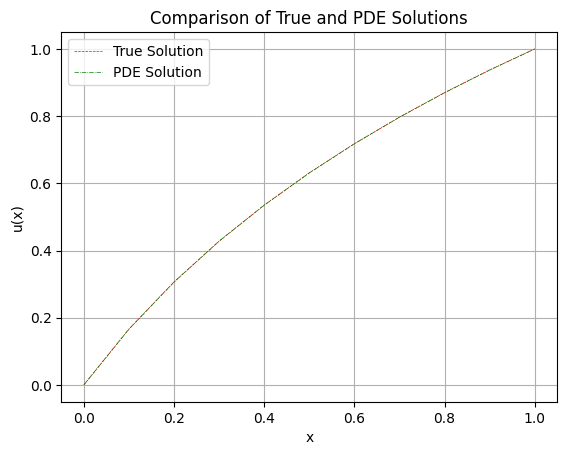

In [8]:
plt.plot(coord, u_true, 'r--',linewidth=0.5, label='True Solution')   # red, dashed, circles
plt.plot(coord, u_pde, 'g-.',linewidth=0.5,label='PDE Solution')      # blue, solid, squares

plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Comparison of True and PDE Solutions")
plt.legend()
plt.grid(True)
plt.show()

In [9]:

dU = u.vector().get_local()[cg2].shape[0]
dM = m.vector().get_local().shape[0]
# once you have modified the means of c->m(c) comment this
print(dU, dM)
uhat = dl.Function(Vh[hp.STATE])
m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
m_nodes_hat_ = dl.Function(Vh[hp.PARAMETER])
Jm_data = np.zeros((dU, dM))
m_values = m_data.copy()
Jm.observable.setLinearizationPoint(x)
# observable.setLinearizationPoint(x)
# Jm = hf.ObservableJacobian(observable)
print(Jm)
for component in range(dM):
    m_hat = np.zeros((dM))
    m_hat[component] = 1
    m_nodes_hat.vector().set_local(m_hat[v2d]) 
    #m_nodes_hat.vector().set_local(M_M.array()[:,component][v2d]) 
    # M_M.mult(m_nodes_hat.vector(), m_nodes_hat_.vector())
    # Jm.mult(m_nodes_hat_.vector(), uhat.vector()) 
    Jm.mult(m_nodes_hat.vector(), uhat.vector()) 
    Jm_data[:,component] = uhat.vector().get_local()[cg2]
Jm_data

11 11


array([[-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [-0.06708679, -0.0499879 ,  0.01557425,  0.01189494,  0.00938282,
         0.00759106,  0.0062681 ,  0.00526344,  0.00448251,  0.00386343,
         0.001757  ],
       [-0.05580058, -0.08895004, -0.02266504,  0.021952  ,  0.01731591,
         0.01400923,  0.01156772,  0.00971363,  0.00827242,  0.00712993,
         0.00324253],
       [-0.046024  , -0.07336549, -0.05369723, -0.00816822,  0.02418787,
         0.01956891,  0.01615847,  0.01356857,  0.0115554 ,  0.0099595 ,
         0.00452936],
       [-0.03740044, -0.05961893, -0.04363593, -0.03332725, -0.00011805,
         0.02447289,  0.0202078 ,  0.01696886,  0.01445119,  0.01245536,
         0.00566442],
       [-0.0296864 , -0.04732221, -0.03463579, -0.02645333, -0.02086659,
         0.00446163,  0.02383005,  0.02001053,  0.01704157,  0.01468798,
         0.006

# We need to test if du/dm is correct or not

In [ ]:
def test_jacobian(m_data_, u_true,  J_true, epsilon):
    m = dl.Function(Vh[hp.PARAMETER])
    u = dl.Function(Vh[hp.STATE])
    uadj = dl.Function(Vh[hp.ADJOINT])
    dU = u.vector().get_local().shape[0]
    dM = m.vector().get_local().shape[0]
    error_total = 0
    error_div_u =0
    # print("J_true\n", J_true)
    for i in range(dM):
        m = dl.Function(Vh[hp.PARAMETER])
        u = dl.Function(Vh[hp.STATE])
        uadj = dl.Function(Vh[hp.ADJOINT])
        m_values_ = m_data_.copy()
        m_values_[i] = m_values_[i] + epsilon
        m.vector().set_local(m_values_[d2v]) #uncomment this
        
        x = [u.vector(),m.vector(),uadj.vector()]
        pde.solveFwd(x[hp.STATE], x)

        u_data_current = x[hp.STATE].get_local()[cg2]
        delta_u  = u_data_current - u_true
        error_div_u = error_div_u + np.linalg.norm(delta_u)
        #print(delta_u)
        Jm_FD_i = (u_data_current - u_true)/epsilon
        # print(Jm_FD_i)
        error = np.linalg.norm(Jm_FD_i - J_true[:,i])
        error_total = error_total + error
    # error_total = np.linalg.norm(delta_u)
    return error_total ,error_div_u
        
        
    
epsilon_data = [1e-10, 1e-9, 1e-8, 1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#epsilon_data = [1e-8]
error_data =[]
error_div_u = []
for eps in epsilon_data:
    #test_jacobian(m_data_=m_data, u_true=u_pde,  J_true=Jm_data, epsilon=eps)
    rms, err = test_jacobian(m_data_=m_data, u_true=u_pde,  J_true=Jm_data, epsilon=eps)
    error_data.append(rms)
    error_div_u.append(err)

/tmp/jt925938/login23-g-1_133314/ipykernel_61892/1628108422.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m.vector().set_local(m_values_[d2v]) #uncomment this


In [11]:
epsilon_data , error_data

([1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1],
 [3.7530155421550517e-06,
  3.7825955695419154e-07,
  2.4586773350749264e-07,
  2.5295056277561186e-06,
  2.5296119167273786e-05,
  0.0002528531015276888,
  0.002517639630844044,
  0.024142857332911348])

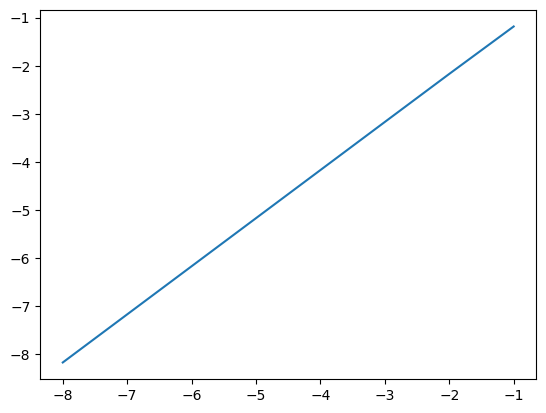

In [12]:
plt.plot(np.log10(epsilon_data), np.log10(error_div_u)) 

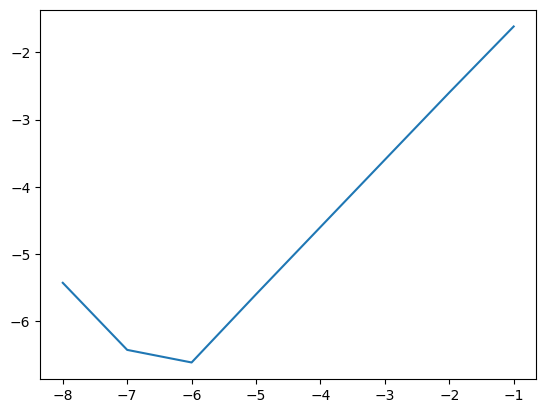

In [13]:
plt.plot(np.log10(epsilon_data), np.log10(error_data)) 